In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/106_cyt01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/094_cyt02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/001_cyt08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/019_nuc09.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/045_nuc02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/042_nuc01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/034_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/041_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc07.dat
/kaggle/input/cervical-cancer-largest-dataset-sipa

In [2]:
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install scipy
!pip install efficientnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 r

In [3]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns


2025-11-29 14:53:43.561504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764428023.837763      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764428023.922655      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# --- 1. CONFIGURATION ---
DATASET_DIR = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed'
WORKING_DIR = '/kaggle/working'
TRAIN_DIR = os.path.join(WORKING_DIR, 'train')
VAL_DIR = os.path.join(WORKING_DIR, 'val')
TEST_DIR = os.path.join(WORKING_DIR, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100  # Increased as requested
LEARNING_RATE = 0.0005 # Lower start rate to prevent model collapse

# Clean working directory
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)


In [5]:
# --- 2. DATA PREPARATION ---
print("--- Organizing Dataset ---")
class_names = [d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))]
class_names.sort()

for class_name in class_names:
    class_path = os.path.join(DATASET_DIR, class_name, class_name)
    if not os.path.exists(class_path):
        class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.exists(class_path): continue

    images = [os.path.join(class_path, f) for f in os.listdir(class_path) 
              if f.lower().endswith(('.bmp', '.jpg', '.png'))]
    if len(images) == 0: continue

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42, shuffle=True)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42, shuffle=True)

    def copy_images(file_list, destination):
        dest_class_dir = os.path.join(destination, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        for img in file_list:
            shutil.copy(img, os.path.join(dest_class_dir, os.path.basename(img)))

    copy_images(train_imgs, TRAIN_DIR)
    copy_images(val_imgs, VAL_DIR)
    copy_images(test_imgs, TEST_DIR)

--- Organizing Dataset ---


In [6]:

# --- 3. ADVANCED DATA AUGMENTATION ---
# Increased augmentation to fight the small dataset size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,          # Increased rotation
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2], # Added brightness variation
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(class_names)

# Class Weights
train_classes = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(train_classes), y=train_classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")


Found 674 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 147 images belonging to 5 classes.
Class Weights: {0: 0.8641025641025641, 1: 0.8120481927710843, 2: 0.7132275132275132, 3: 1.7973333333333332, 4: 1.5318181818181817}


In [7]:
# --- 4. ROBUST CUSTOM CNN MODEL ---
def build_robust_cnn():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1)) # LeakyReLU helps gradients flow better
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2)) # Light dropout in conv layers
    
    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # Block 4
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
     # Classification Head
    model.add(GlobalAveragePooling2D()) 
    
    model.add(Dense(256, kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5)) # Heavy dropout before output
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_robust_cnn()
model.summary()
    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-29 14:55:53.614157: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 458,437 (1.75 MB)

 Trainable params: 456,965 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [8]:
# --- 5. TRAINING ---
# Increased patience so it doesn't stop at 12% accuracy
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

# Aggressive learning rate reduction if stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-7, 
    verbose=1
)

print("\n--- Starting Training (100 Epochs) ---")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


--- Starting Training (100 Epochs) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.3117 - loss: 1.7979 - val_accuracy: 0.1103 - val_loss: 1.7246 - learning_rate: 5.0000e-04
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.4841 - loss: 1.4428 - val_accuracy: 0.1103 - val_loss: 1.8816 - learning_rate: 5.0000e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.5766 - loss: 1.0923 - val_accuracy: 0.1103 - val_loss: 2.1362 - learning_rate: 5.0000e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.5416 - loss: 1.2254 - val_accuracy: 0.1103 - val_loss: 2.6281 - learning_rate: 5.0000e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.6342 - loss: 1.0487 - val_accuracy: 0.1103 - val_loss: 2.8061 - learning_rate: 5.0000e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5930 - loss: 1.1247
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.5925 - lo

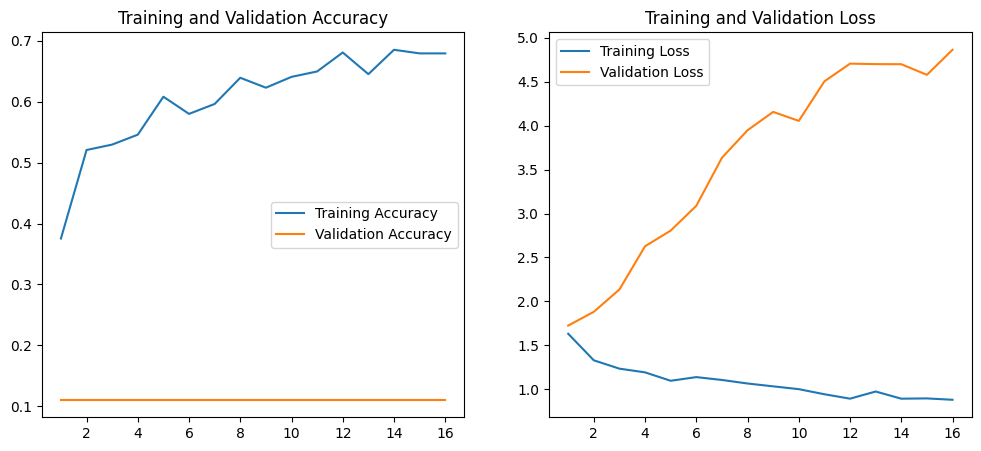

In [9]:
# --- 6. PLOTTING ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [10]:
# --- 7. EVALUATION & PER-CLASS ACCURACY ---
print("\n--- Final Evaluation ---")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
target_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names))



--- Final Evaluation ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.00      0.00      0.00        34
            im_Koilocytotic       0.00      0.00      0.00        36
             im_Metaplastic       0.00      0.00      0.00        41
               im_Parabasal       0.12      1.00      0.21        17
im_Superficial-Intermediate       0.00      0.00      0.00        19

                   accuracy                           0.12       147
                  macro avg       0.02      0.20      0.04       147
               weighted avg       0.01      0.12      0.02       147



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


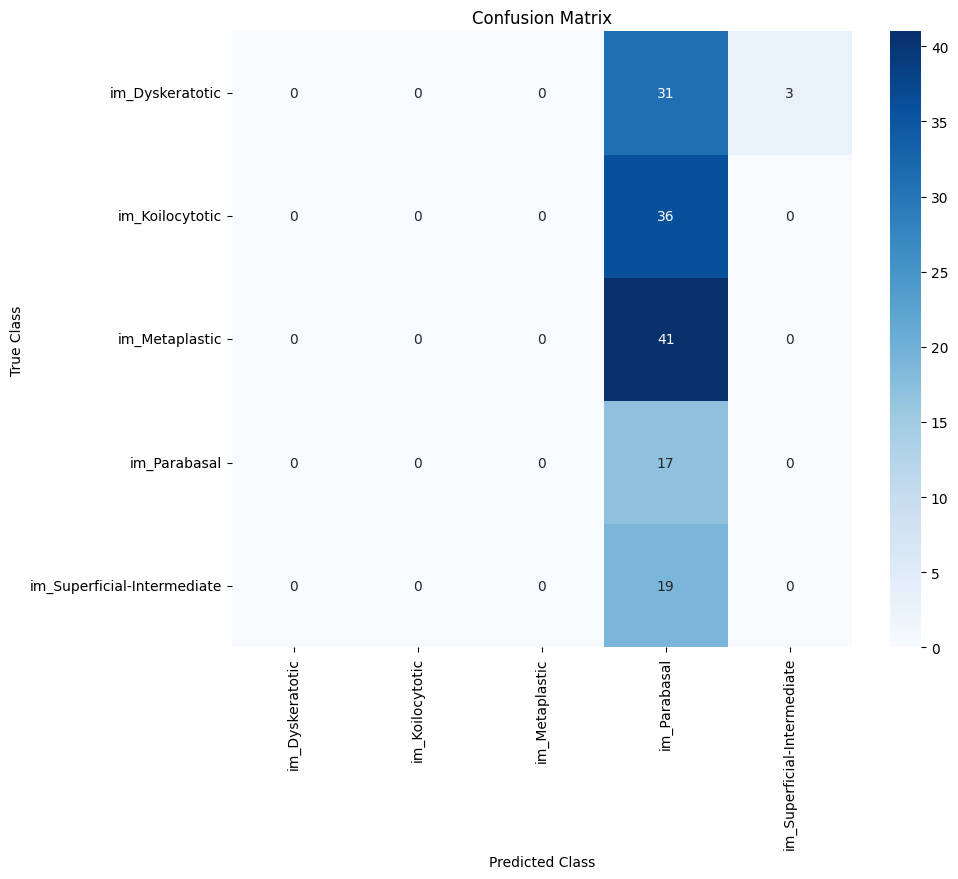

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()



=== Per-Class Accuracy ===
im_Dyskeratotic: 0.00%
im_Koilocytotic: 0.00%
im_Metaplastic: 0.00%
im_Parabasal: 100.00%
im_Superficial-Intermediate: 0.00%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


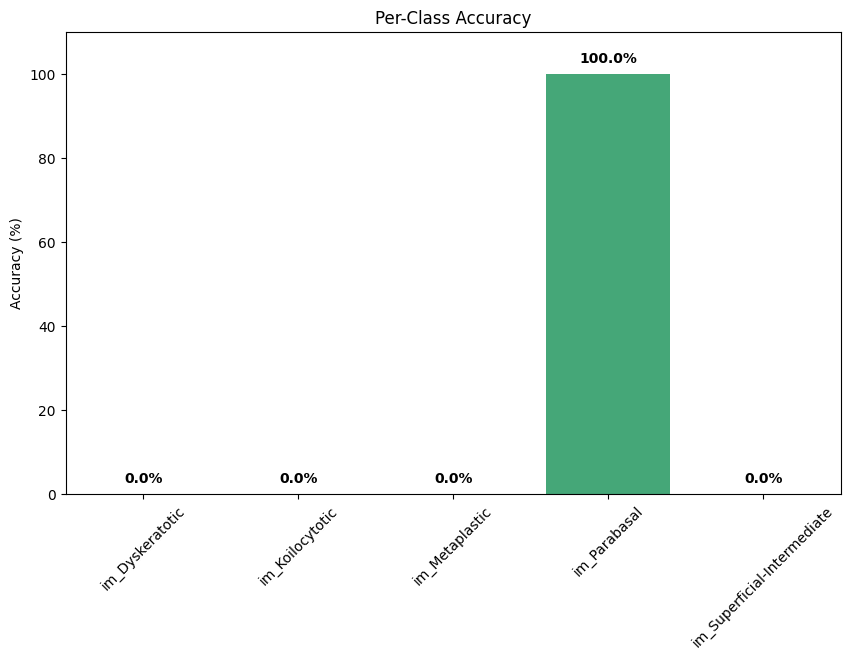

In [12]:
# Calculate Per-Class Accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\n=== Per-Class Accuracy ===")
for i, acc in enumerate(per_class_accuracy):
    print(f"{target_names[i]}: {acc * 100:.2f}%")

# Plot Per-Class Accuracy
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=target_names, y=per_class_accuracy * 100, palette="viridis")
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.ylim(0, 110)
for i, v in enumerate(per_class_accuracy * 100):
    barplot.text(i, v + 2, f"{v:.1f}%", ha='center', va='bottom', fontweight='bold')
plt.show()

--- Organizing Dataset ---
Found 674 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 147 images belonging to 5 classes.
Class Weights: {0: 0.8641025641025641, 1: 0.8120481927710843, 2: 0.7132275132275132, 3: 1.7973333333333332, 4: 1.5318181818181817}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 458,437 (1.75 MB)

 Trainable params: 456,965 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)


--- Starting Training (100 Epochs) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.3355 - loss: 1.8138 - val_accuracy: 0.1103 - val_loss: 1.7527 - learning_rate: 5.0000e-04
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.4807 - loss: 1.3452 - val_accuracy: 0.1103 - val_loss: 1.8598 - learning_rate: 5.0000e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.5498 - loss: 1.2323 - val_accuracy: 0.1103 - val_loss: 2.2540 - learning_rate: 5.0000e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.6081 - loss: 1.0468 - val_accuracy: 0.1103 - val_loss: 2.5920 - learning_rate: 5.0000e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.5713 - loss: 1.0983 - val_accuracy: 0.1103 - val_loss: 3.2645 - learning_rate: 5.0000e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5673 - loss: 1.1398
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
22/22 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.5677 - l

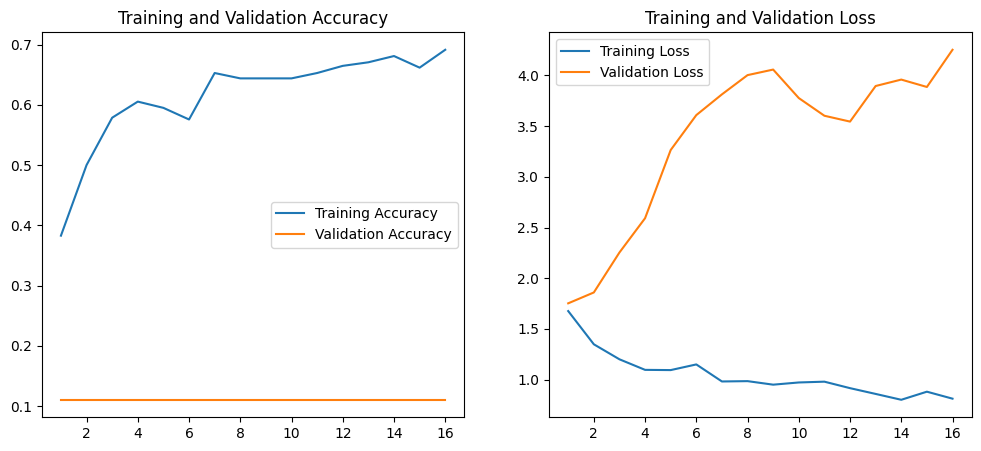


--- Final Evaluation ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.00      0.00      0.00        34
            im_Koilocytotic       0.00      0.00      0.00        36
             im_Metaplastic       0.00      0.00      0.00        41
               im_Parabasal       0.12      1.00      0.21        17
im_Superficial-Intermediate       0.00      0.00      0.00        19

                   accuracy                           0.12       147
                  macro avg       0.02      0.20      0.04       147
               weighted avg       0.01      0.12      0.02       147



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


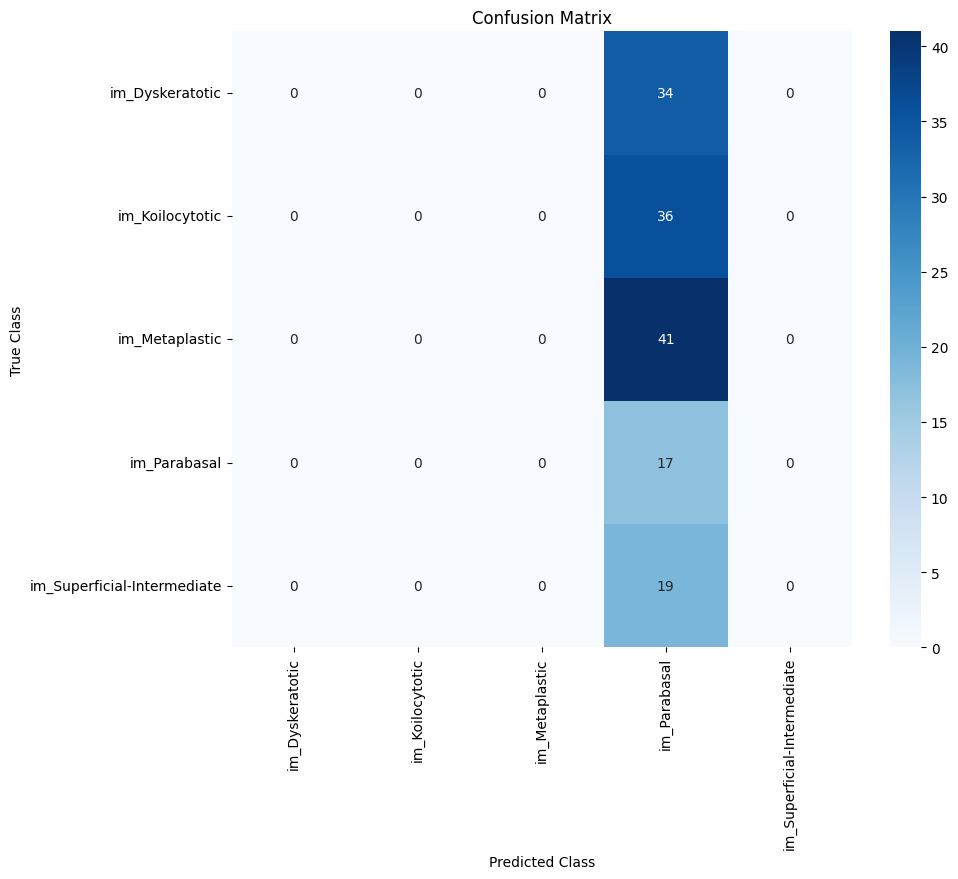


=== Per-Class Accuracy ===
im_Dyskeratotic: 0.00%
im_Koilocytotic: 0.00%
im_Metaplastic: 0.00%
im_Parabasal: 100.00%
im_Superficial-Intermediate: 0.00%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


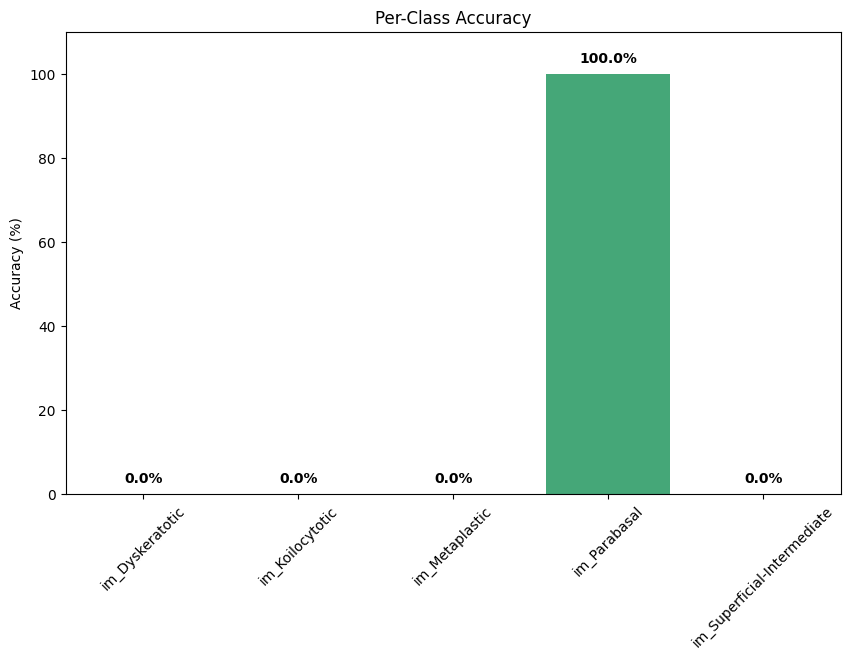

In [13]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns

# --- 1. CONFIGURATION ---
DATASET_DIR = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed'
WORKING_DIR = '/kaggle/working'
TRAIN_DIR = os.path.join(WORKING_DIR, 'train')
VAL_DIR = os.path.join(WORKING_DIR, 'val')
TEST_DIR = os.path.join(WORKING_DIR, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100  # Increased as requested
LEARNING_RATE = 0.0005 # Lower start rate to prevent model collapse

# Clean working directory
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# --- 2. DATA PREPARATION ---
print("--- Organizing Dataset ---")
class_names = [d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))]
class_names.sort()

for class_name in class_names:
    class_path = os.path.join(DATASET_DIR, class_name, class_name)
    if not os.path.exists(class_path):
        class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.exists(class_path): continue

    images = [os.path.join(class_path, f) for f in os.listdir(class_path) 
              if f.lower().endswith(('.bmp', '.jpg', '.png'))]
    if len(images) == 0: continue

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42, shuffle=True)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42, shuffle=True)

    def copy_images(file_list, destination):
        dest_class_dir = os.path.join(destination, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        for img in file_list:
            shutil.copy(img, os.path.join(dest_class_dir, os.path.basename(img)))

    copy_images(train_imgs, TRAIN_DIR)
    copy_images(val_imgs, VAL_DIR)
    copy_images(test_imgs, TEST_DIR)

# --- 3. ADVANCED DATA AUGMENTATION ---
# Increased augmentation to fight the small dataset size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,          # Increased rotation
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2], # Added brightness variation
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(class_names)

# Class Weights
train_classes = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(train_classes), y=train_classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

# --- 4. ROBUST CUSTOM CNN MODEL ---
def build_robust_cnn():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1)) # LeakyReLU helps gradients flow better
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2)) # Light dropout in conv layers
    
    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # Block 4
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # Classification Head
    model.add(GlobalAveragePooling2D()) 
    
    model.add(Dense(256, kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5)) # Heavy dropout before output
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_robust_cnn()
model.summary()

# --- 5. TRAINING ---
# Increased patience so it doesn't stop at 12% accuracy
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

# Aggressive learning rate reduction if stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-7, 
    verbose=1
)

print("\n--- Starting Training (100 Epochs) ---")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

# --- 6. PLOTTING ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

# --- 7. EVALUATION & PER-CLASS ACCURACY ---
print("\n--- Final Evaluation ---")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
target_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Calculate Per-Class Accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\n=== Per-Class Accuracy ===")
for i, acc in enumerate(per_class_accuracy):
    print(f"{target_names[i]}: {acc * 100:.2f}%")

# Plot Per-Class Accuracy
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=target_names, y=per_class_accuracy * 100, palette="viridis")
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.ylim(0, 110)
for i, v in enumerate(per_class_accuracy * 100):
    barplot.text(i, v + 2, f"{v:.1f}%", ha='center', va='bottom', fontweight='bold')
plt.show()